In [1]:
import gym
import random
import numpy as np
import time
import torch

from gym.envs.classic_control import rendering 

In [2]:
def repeat_upsample(rgb_array, k=1, l=1, err=[]):
    # repeat kinda crashes if k/l are zero
    if k <= 0 or l <= 0: 
        if not err: 
            print("Number of repeats must be larger than 0, k: {}, l: {}, returning default array!".format(k, l))
            err.append('logged')
        return rgb_array

    # repeat the pixels k times along the y axis and l times along the x axis
    # if the input image is of shape (m,n,3), the output image will be of shape (k*m, l*n, 3)

    return np.repeat(np.repeat(rgb_array, k, axis=0), l, axis=1)

In [41]:
viewer_S = rendering.SimpleImageViewer()
viewer_A = rendering.SimpleImageViewer()
viewer_D = rendering.SimpleImageViewer()

In [7]:
env_S = gym.make('SpaceInvaders-v0')
print("Action Space: ", env_S.action_space)
print("Observation Space: ", env_S.observation_space)

Action Space:  Discrete(6)
Observation Space:  Box(210, 160, 3)


In [5]:
env_A = gym.make('Assault-v0')
print("Action Space: ", env_A.action_space)
print("Observation Space: ", env_A.observation_space)

Action Space:  Discrete(7)
Observation Space:  Box(250, 160, 3)


In [6]:
env_D = gym.make('DemonAttack-v0')
print("Action Space: ", env_D.action_space)
print("Observation Space: ", env_D.observation_space)

Action Space:  Discrete(6)
Observation Space:  Box(210, 160, 3)


In [7]:
class Agent_all():
    def __init__(self, env):
        # 0 = nothing, 1 = fire, 2 = right, 3 = left
        self.common_actions = [0, 1, 2, 3]
        self.assult_translation = {0:1, 1:2, 2:3, 3:4}
    
    def get_action(self, state):
        base_action = random.choice(self.common_actions)
        
        assault_action = self.assult_translation[base_action]
        
        return base_action, base_action, assault_action

In [9]:
state_S = env_S.reset()
state_A = env_A.reset()
state_D = env_D.reset()

In [8]:
agent = Agent_all(env_S)

for _ in range(2000):
    action_S, action_D, action_A = agent.get_action(state_S)
    
    state_S, reward_S, done_S, info_S = env_S.step(action_S)
    
    rgb_S = env_S.render('rgb_array')
    rgb_S = rgb_S[22:195, :, :]
    viewer_S.imshow(repeat_upsample(rgb_S, 3, 3))
    
    state_A, reward_A, done_A, info_A = env_A.step(action_A)
    
    rgb_A = env_A.render('rgb_array')
    rgb_A = rgb_A[51:195+29, :, :]
    viewer_A.imshow(repeat_upsample(rgb_A, 3, 3))
    
    state_D, reward_D, done_D, info_D = env_D.step(action_D)
    
    rgb_D = env_D.render('rgb_array')
    rgb_D = rgb_D[15:188, :, :]
    viewer_D.imshow(repeat_upsample(rgb_D, 3, 3))
    
    #time.sleep(0.1)
    if done_S & done_A & done_D:
        break
    
    

In [13]:
rgb_A.mean(axis=2).shape

(250, 160)

SI: 0 = nothing, 1 = fire, 2 = right, 3 = left, 4 = right + fire, 5 = left + fire  
A:  0 = nothing, 1 = nothing?, 2 = fire, 3 = right, 4 = left, 5 = shoot right, 6 = shoot left  
DA: 0 = nothing, 1 = fire, 2 = right, 3 = left, 4 = right + fire, 5 = left + fire  

# Tutorial
Full code, but using tensorflow
 - https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Space%20Invaders/DQN%20Atari%20Space%20Invaders.ipynb  
 - https://www.youtube.com/watch?v=gCJyVX98KJ4

Using Pytorch
 - https://www.youtube.com/watch?v=RfNxXlO6BiA

Also
 - https://www.youtube.com/watch?v=dpBKz1wxE_c
 
Frame Skipping and Stacking
 - https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/
 
General DQN Walkthrough =
 - https://medium.com/@jonathan_hui/rl-dqn-deep-q-network-e207751f7ae4

In [2]:
import numpy as np           # Handle matrices

from skimage import transform # Help us to preprocess the frames
from skimage.color import rgb2gray # Help us to gray our frames

import matplotlib.pyplot as plt # Display graphs

from collections import deque# Ordered collection with ends

import random

import warnings # This ignore all the warning messages that are normally printed during the training because of skiimage
warnings.filterwarnings('ignore')

In [3]:
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
# Create our environment
env = gym.make('SpaceInvaders-v0')

print("Action Space: ", env.action_space)
print("Observation Space: ", env.observation_space)

# Here we create an hot encoded version of our actions
# possible_actions = [[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0]...]
#possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())
# - His env takes a one hot vector as the action. Ours just takes an integer

possible_actions = range(4)

Action Space:  Discrete(6)
Observation Space:  Box(210, 160, 3)


In [5]:
possible_actions

range(0, 4)

In [73]:
def preprocess_frame(frame):
    # Grayscale frame 
    gray = rgb2gray(frame)
    
    # Crop the screen (remove the part below the player)
    # [Up: Down, Left: right]
    cropped_frame = gray[22:195,4:-12]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    # Thanks to Mikołaj Walkowiak
    preprocessed_frame = transform.resize(normalized_frame, [110,84])
    
    return preprocessed_frame # 110x84x1 frame

In [74]:
def stack_frames(stacked_frames, state, is_new_episode, stack_size=4):
    # Preprocess frame
    # https://github.com/openai/gym/issues/275 - Env is already skipping frames
    # Stacked_frames = the queue, stacked_state = an array of the same information
    frame = preprocess_frame(state)
    frame = T.Tensor(frame)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([T.zeros((110,84)) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        for i in range(stack_size):
            stacked_frames.append(frame)
        
        # Build the stacked state (first dimension specifies different frames)
        stacked_state = T.stack(list(stacked_frames), dim=2)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = T.stack(list(stacked_frames), dim=2) 
    
    return stacked_state, stacked_frames

In [75]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, transition):
        self.buffer.append(transition)
    
    def sample(self, batch_size, consecutive=False):
        buffer_size = len(self.buffer)
        
        if consecutive:
            rand_start = np.random.choice(range(buffer_size - batch_size - 1))
            sample = [self.buffer[i] for i in range(rand_start, rand_start + batch_size)]
        else:
            random_indices = np.random.choice(np.arange(buffer_size),
                                    size = batch_size,
                                    replace = False)
            sample = [self.buffer[i] for i in random_indices]
        
        
        return sample

In [76]:
def conv2d_size_out(size, kernel_size = 5, stride = 2):
    """
    Number of Linear input connections depends on output of conv2d layers
    and therefore the input image size, so compute it.
    """
    out_size = (size - (kernel_size - 1) - 1) // stride  + 1

    return out_size

In [77]:
class DQN(nn.Module):

    def __init__(self, frame_shape, num_outputs, alpha):
        super(DQN, self).__init__()
        self.alpha = alpha
        
        h, w = frame_shape
        
        self.conv1 = nn.Conv2d(4, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        self.linear_input_size = convw * convh * 32
        
        self.fc1 = nn.Linear(self.linear_input_size, 512)
        self.fc2 = nn.Linear(512, num_outputs)
        
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.loss = nn.MSELoss()
        

    # Called with either one element to determine next action, or a batch
    # during optimization.
    def forward(self, x):
        batch_shape = x.shape
        x = T.Tensor(x).to(self.device)
        
        # Must transpose it - comes in as (h, w, frames). Change to (frames, h, w)
        x = x.view(batch_shape[0], batch_shape[3], batch_shape[1], batch_shape[2])

        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        # Flatten 
        x = x.view(-1, self.linear_input_size)
        
        # Linear layers
        x = F.relu(self.fc1(x))
        q_vals = F.relu(self.fc2(x))
        
        # q_vals is a q value for each action for each item in minibatch (Eg: 32 * 4)
        
        return q_vals


In [93]:
class Agent(object):
    
    def __init__(self, frame_shape, gamma, epsilon_start, epsilon_end, epsilon_decay, 
                 alpha, max_memory, replace, action_space):
        self.gamma = gamma # Discount factor
        self.epsilon_start = epsilon_start # For greedy action selection
        self.epsilon_end = epsilon_end #How low epsilon can go
        self.epsilon_decay = epsilon_decay
        self.replace = replace # How often to replace target network
        self.action_space = action_space
        
        self.steps = 0
        self.learn_step_counter = 0 #How many times we've called learn function - For target network replacement
        self.memory = Memory(max_memory)
        
        self.replace_target = replace
        
        self.Q_eval = DQN(frame_shape, len(action_space), alpha) # Agent's estimate of current set of states' Q
        self.Q_next = DQN(frame_shape, len(action_space), alpha) # Agent's estimage of next set of states' Q
        
        
    def storeTransition(self, state, action, reward, result_state, done):
        """
        Wrap the inputs into a "Transition" and puts in in memory 
        """
        transition = (state, action, reward, result_state, done)
        self.memory.add(transition)
        
        
    def chooseAction(self, observation):
        """
        Epsilon Greedy strategy with decaying exploration prob.
        """
        rand = np.random.rand()
        
        # Lower the exploration probability over time in accordance with 
        #  the number of times the model has learned 
        explore_probability = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                              np.exp(-self.epsilon_decay * self.learn_step_counter)
        
        if rand < explore_probability:
            action = np.random.choice(self.action_space)
            
        else:
            actions_pred = self.Q_eval.forward(observation)
                 
            # Take first axis because actions returned as a matrix (1 x num_actions) 
            action = T.argmax(actions_pred[0]).item()
            
        self.steps += 1
            
        return action, explore_probability
    
    
    def learn(self, batch_size, consecutive_bool):
        """
        Batch learn
        """
        # Zero gradients for next batch
        self.Q_eval.optimizer.zero_grad()
        
        # Target network replacement
        if (self.replace_target is not None) & (self.learn_step_counter % self.replace_target == 0):
            print('replacing target')
            self.Q_next.load_state_dict(self.Q_eval.state_dict())
            
        # Get a minibatch
        minibatch = self.memory.sample(batch_size, consecutive=consecutive_bool) # Not sure they need to be consec
        
        batch_states =   T.stack([i[0] for i in minibatch]).to(self.Q_eval.device)
        batch_actions =  T.LongTensor([i[1] for i in minibatch]).to(self.Q_eval.device)
        batch_rewards =  T.Tensor([i[2] for i in minibatch]).to(self.Q_eval.device)
        batch_next_states = T.stack([i[3] for i in minibatch]).to(self.Q_eval.device)
        done_bools =  T.Tensor([i[4] for i in minibatch]).to(self.Q_eval.device)
        rewards = T.Tensor(batch_rewards).to(self.Q_eval.device)
        
        # Get predictions from both networks
        Qpred = self.Q_eval.forward(batch_states).to(self.Q_eval.device)
        Qnext = self.Q_next.forward(batch_next_states).to(self.Q_next.device)
        
        max_Q_next, max_action = T.max(Qnext, dim=1)
        
        predictions = Qpred.gather(1, batch_actions.view(-1, 1)).squeeze()

        # We want loss function to be zero for all actions except max - Video 2: 16:30ish
        targets = rewards + self.gamma*max_Q_next 
        targets = torch.where(done_bools != 1, targets, batch_rewards)
        
        print('prediction sum', predictions.sum())
        print('target sum', targets.sum())
        
        # Get loss and backprob
        loss = self.Q_eval.loss(targets, predictions).to(self.Q_eval.device)
        print('loss', loss.item())
        loss.backward()
        self.Q_eval.optimizer.step()
        
        self.learn_step_counter += 1
        print()
        
        return loss.item()
        

In [94]:
def initial_fill_mem(agent, pretrain_length, env):
    """
    Start filling the memory of the agent with a bunch of random moves and transitions to start learning from.
    
    Pretrain length should be at least 1 batchsize
    """
    # Initialize deque with zero-images one array for each image
    stacked_frames = deque([T.zeros((110,84)) for i in range(stack_size)], maxlen=4)
    
    possible_actions = agent.action_space
    
    frame = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, frame, is_new_episode=False)
    
    prior_num_lives = 3 
    
    for i in range(pretrain_length):

        # Get the next_state and the reward, done by taking a random action
        action = np.random.choice(possible_actions)
        next_frame, reward, done, info = env.step(action)
        num_lives = info['ale.lives']
        
        if num_lives < prior_num_lives:
            reward = -20.0
            
        prior_num_lives = num_lives

        if episode_render: env.render()

        # Stack the frames
        next_state, stacked_frames = stack_frames(stacked_frames, next_frame, is_new_episode=False)

        # If the episode is finished (we're dead 3x), then store a 0 next state and restart the env.
        if done:
            # We finished the episode
            next_state = np.zeros(next_state.shape)

            # Add experience to memory
            agent.storeTransition(state, action, reward, next_state, done)

            # Start a new episode
            frame = env.reset()

            # Stack the frames
            state, stacked_frames = stack_frames(stacked_frames, frame, is_new_episode=True)

        else:
            # Add experience to memory
            agent.storeTransition(state, action, reward, next_state, done)

            # Our new state is now the next_state
            state = next_state
            
    return stacked_frames
    

### Running

In [108]:
### MODEL HYPERPARAMETERS
frame_shape = [110, 84]
state_size = [110, 84, 4]         # Our input is a stack of 4 frames hence 110x84x4 (Width, height, channels) 
alpha =  0.000025          # Alpha (aka learning rate)
action_space = range(4)

### TRAINING HYPERPARAMETERS
total_episodes = 50            # Total episodes for training
max_steps = 50000              # Max possible steps in an episode
batch_size = 64                # Batch size
target_net_replace = 10000     # Target network replacement

# Exploration parameters for epsilon greedy strategy
epsilon_start = 1.0            # exploration probability at start
epsilon_end = 0.01            # minimum exploration probability 
epsilon_decay = 0.00001           # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.9                    # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length =  200         # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000             # Number of experiences the Memory can keep
consecutive_bool = False

### PREPROCESSING HYPERPARAMETERS
stack_size = 4                 # Number of frames stacked

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = True

In [113]:
agent = Agent(frame_shape, gamma, epsilon_start, epsilon_end, epsilon_decay, 
              alpha, memory_size, target_net_replace, action_space)

In [114]:
stacked_frames = initial_fill_mem(agent, pretrain_length, env)

AxesImage(72,36;446.4x217.44)
AxesImage(72,36;446.4x217.44)


(0, 0.0)

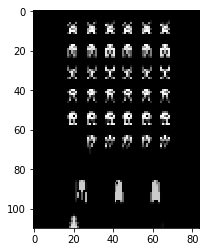

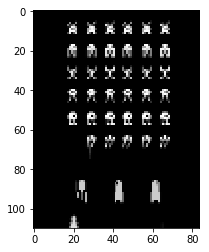

In [115]:
mem_element = 160

fig=plt.figure(figsize=(8, 4))
print(plt.imshow(agent.memory.buffer[mem_element][0].sum(dim=2), cmap=plt.cm.gray))
fig=plt.figure(figsize=(8, 4))
print(plt.imshow(agent.memory.buffer[mem_element][3].sum(dim=2), cmap=plt.cm.gray))
agent.memory.buffer[mem_element][1], agent.memory.buffer[mem_element][2]

In [116]:
[(i, e[1], e[2]) for i, e in enumerate(agent.memory.buffer)]

[(0, 1, 0.0),
 (1, 2, 0.0),
 (2, 3, 0.0),
 (3, 1, 0.0),
 (4, 3, 0.0),
 (5, 3, 0.0),
 (6, 3, 0.0),
 (7, 3, 0.0),
 (8, 0, 0.0),
 (9, 0, 0.0),
 (10, 2, 0.0),
 (11, 3, 0.0),
 (12, 1, 0.0),
 (13, 3, 0.0),
 (14, 0, 0.0),
 (15, 0, 0.0),
 (16, 3, 0.0),
 (17, 3, 0.0),
 (18, 3, 0.0),
 (19, 2, 0.0),
 (20, 3, 0.0),
 (21, 3, 0.0),
 (22, 3, 0.0),
 (23, 2, 0.0),
 (24, 1, 0.0),
 (25, 0, 0.0),
 (26, 2, 0.0),
 (27, 2, 0.0),
 (28, 2, 0.0),
 (29, 2, 0.0),
 (30, 2, 0.0),
 (31, 2, 0.0),
 (32, 0, 0.0),
 (33, 1, 0.0),
 (34, 3, 0.0),
 (35, 3, 0.0),
 (36, 2, 0.0),
 (37, 2, 0.0),
 (38, 1, 0.0),
 (39, 1, 0.0),
 (40, 2, 0.0),
 (41, 0, 0.0),
 (42, 1, 0.0),
 (43, 0, 0.0),
 (44, 1, 0.0),
 (45, 1, 0.0),
 (46, 0, 0.0),
 (47, 1, 0.0),
 (48, 2, 0.0),
 (49, 3, 0.0),
 (50, 2, 0.0),
 (51, 3, 0.0),
 (52, 0, 0.0),
 (53, 1, 0.0),
 (54, 2, 0.0),
 (55, 1, 0.0),
 (56, 3, 0.0),
 (57, 1, 0.0),
 (58, 1, 0.0),
 (59, 1, 0.0),
 (60, 1, 0.0),
 (61, 1, 0.0),
 (62, 2, 0.0),
 (63, 1, 0.0),
 (64, 0, 0.0),
 (65, 0, 0.0),
 (66, 1, 0.0),
 (67,

In [ ]:
# Train the Model! - Still needs work

for episode in range(total_episodes):
    # Set episode_steps to 0
    episode_steps = 0
    done = False

    # Initialize the rewards of the episode
    episode_rewards = [] 
    episode_losses = []

    # Make a new episode and observe the first state
    frame = env.reset()
    prior_num_lives = 3

    # Remember that stack frame function also call our preprocess function.
    state, stacked_frames = stack_frames(stacked_frames, frame, is_new_episode=True)

    while (episode_steps < max_steps) & (~done):
        episode_steps += 1

        # Predict the action to take and take it
        action, explore_probability = agent.chooseAction(state.unsqueeze(0))
        
        #Perform the action and get the next_state, reward, and done information
        next_frame, reward, done, info = env.step(action)
        num_lives = info['ale.lives']
        
        if num_lives < prior_num_lives:
            reward = -20.0
            
        prior_num_lives = num_lives

        if episode_render:
            env.render()

        # Add the reward to total reward
        episode_rewards.append(reward)

        # If the game is finished
        if done:
            # The episode ends so no next state
            next_frame = np.zeros((110,84), dtype=np.int)

            next_state, stacked_frames = stack_frames(stacked_frames, next_frame, is_new_episode=False)

            # Get the total reward of the episode
            total_reward = sum(episode_rewards)
            mean_loss = sum(episode_losses)/len(episode_losses)

            print('Episode: {}'.format(episode),
                  'Total reward: {}'.format(total_reward),
                  'Explore P: {:.4f}'.format(explore_probability),
                  'Mean Training Loss {:.4f}'.format(mean_loss))

            # Store transition <st,at,rt+1,st+1> in memory D
            agent.storeTransition(state, action, reward, next_state, done)

        else:
            # Stack the frame of the next_state
            next_state, stacked_frames = stack_frames(stacked_frames, next_frame, is_new_episode=False)

            # Add experience to memory
            agent.storeTransition(state, action, reward, next_state, done)

            # st+1 is now our current state
            state = next_state


        ### LEARNING PART   
        if episode_steps % 5 == 0:
            loss = agent.learn(batch_size, consecutive_bool)
            episode_losses.append(loss)

replacing target
prediction sum tensor(4.6162, grad_fn=<SumBackward0>)
target sum tensor(19.9516, grad_fn=<SumBackward0>)
loss 1.6601818799972534

prediction sum tensor(5.3170, grad_fn=<SumBackward0>)
target sum tensor(19.7816, grad_fn=<SumBackward0>)
loss 1.6549592018127441

prediction sum tensor(6.4198, grad_fn=<SumBackward0>)
target sum tensor(20.1570, grad_fn=<SumBackward0>)
loss 1.6286089420318604

prediction sum tensor(8.1771, grad_fn=<SumBackward0>)
target sum tensor(14.7928, grad_fn=<SumBackward0>)
loss 0.4237777292728424

prediction sum tensor(9.5858, grad_fn=<SumBackward0>)
target sum tensor(9.9596, grad_fn=<SumBackward0>)
loss 0.006670095957815647

prediction sum tensor(7.7380, grad_fn=<SumBackward0>)
target sum tensor(9.0788, grad_fn=<SumBackward0>)
loss 0.009276671335101128

prediction sum tensor(9.4628, grad_fn=<SumBackward0>)
target sum tensor(9.1704, grad_fn=<SumBackward0>)
loss 0.006241996772587299

prediction sum tensor(9.6101, grad_fn=<SumBackward0>)
target sum tenso